# Simulate Transactions Matrix

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [2]:
item_file = "../input/talent.pkl"
item_records, COLUMN_LABELS, READABLE_LABELS, ATTRIBUTES = pickle.load(open(item_file, "rb"))
df = pd.DataFrame(item_records)[ATTRIBUTES + COLUMN_LABELS].fillna(value=0)
ITEM_NAMES = df["name"].values
ITEM_IDS = df["id"].values
df.head()

,id,name,price,reactions,stars,joined,categories,in_13_reasons_why,in_90_day_fiance,in_actors,...,in_ufc,in_vanderpump_rules,in_venture_capitalists,in_viners,in_vlog_squad,in_voice_actors,in_winter_sports,in_writers,in_younow,in_youtubers
0,perezhilton,Perez Hilton,27.0,924,5.0,April 2018,"[Reality TV, Commentators, Featured]",0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,andydick,Andy Dick,99.0,340,4.9,October 2018,"[Reality TV, Comedians, Featured, Actors]",0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,tjlavin,TJ Lavin,80.0,291,5.0,February 2018,"[Reality TV, Riders, Featured, Extreme Sports,...",0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,carsonkressley,Carson Kressley,59.0,290,5.0,October 2018,"[Reality TV, Bravo, Stylists, Featured, Actors...",0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,riffraff,RiFF RAFF,75.0,402,4.7,December 2017,"[Rappers, Featured, Musicians]",0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
COLUMN_TO_READABLE = {}
READABLE_TO_COLUMN = {}
for column, readable in zip(COLUMN_LABELS, READABLE_LABELS):
    COLUMN_TO_READABLE[column] = readable
    READABLE_TO_COLUMN[readable] = column

## Properties of a Good Transaction Matrix

- **Sparsity:** The number of actual transactions is far smaller than the number of possible transactions.
- **Diversity:** The set of items purchased by a user has some variety.
- **Power Law:** The frequency of items appears to follow a long-tailed distribution, i.e., a small number of items accounts for a large amount of transactions and most items are purchased infrequently.

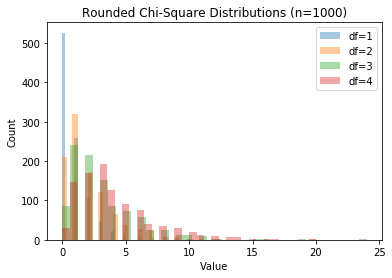

In [4]:
np.random.seed(0)
n_samples = 1000
for d in range(1, 5):
    vals = np.round(np.random.chisquare(df=d, size=n_samples)).astype(int)
    sns.distplot(vals, kde=False, label="df={}".format(d))
plt.xlabel("Value")
plt.ylabel("Count")
plt.title("Rounded Chi-Square Distributions (n={})".format(n_samples))
plt.legend()
plt.show()

## User Likes Simulation

In [5]:
category_map = {}
for category in COLUMN_LABELS:
    talent = df.query("{} == 1".format(category))["id"].values
    reactions = df.query("{} == 1".format(category))["reactions"].values
    freqs = reactions / np.sum(reactions)
    category_map[category] = {
        "talent": talent,
        "freqs": freqs
    }
all_talent = df["id"].values
all_reactions = df["reactions"].values
all_freqs = all_reactions / np.sum(all_reactions)
all_categories = df["categories"].values
talent_map = {}
for talent_id, category_list in zip(all_talent, all_categories):
    talent_map[talent_id] = [READABLE_TO_COLUMN[cat] for cat in category_list]

In [6]:
def simulate_transactions(n, degs=3, min_m=0, seed=0):
    np.random.seed(seed)
    added_transacs = np.round(np.random.chisquare(df=degs, size=n)).astype(int) + min_m
    res = []
    for i, m in enumerate(added_transacs):
        first_id = np.random.choice(all_talent, p=all_freqs)
        cat_set = set(talent_map[first_id])
        talent_set = set([first_id])
        for j in range(m):
            cat = np.random.choice(np.array(list(cat_set)))
            entry = category_map[cat]
            next_id = np.random.choice(entry["talent"], p=entry["freqs"])
            if next_id not in talent_set:
                talent_set.add(next_id)
                # Want to balance between diverse and similar categories
                if len(talent_set) < 1:
                    cat_set.update(talent_map[next_id])
        while len(talent_set) < min_m:
            rand_id = np.random.choice(all_talent, p=all_freqs)
            if rand_id not in talent_set:
                talent_set.add(rand_id)
        res.append({
            "transactions": talent_set,
            "categories": cat_set
        })
    return res

In [7]:
from sklearn.preprocessing import MultiLabelBinarizer

N = 5000
res = simulate_transactions(n=N, degs=3, min_m=6, seed=42)
trans_df = pd.DataFrame(res)
trans_df.head()

,categories,transactions
0,"{in_featured, in_spotlight, in_singer_songwriter}","{ramona56, duncanjames, codyko, carsonkressley..."
1,"{in_lifestyle, in_animals}","{mrwonderful, fabfitfunnygirl, the_kardoggians..."
2,"{in_below_deck, in_reality_tv, in_bravo}","{happycucu, peter_madrigal, colin_macyotoole, ..."
3,"{in_comedians, in_actors, in_reality_tv, in_fe...","{hexofspades, helloworldcatfish, carsonkressle..."
4,"{in_singer_songwriter, in_musicians}","{tarynmanning, itzemmamichelle, vicmensa, lili..."


## User Interest Simulation

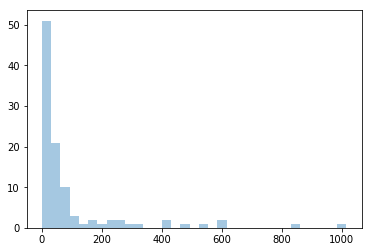

in_actors                   1015.0
in_athletes                  846.0
in_youtubers                 609.0
in_reality_tv                586.0
in_models                    546.0
in_singer_songwriter         478.0
in_musicians                 407.0
in_comedians                 407.0
in_football                  334.0
in_instagram_influencers     286.0
in_fitness                   268.0
in_bloggers                  248.0
in_lifestyle                 235.0
in_rappers                   217.0
in_artists                   197.0
in_dancers                   181.0
in_featured                  178.0
in_tiktok                    128.0
in_bravo                     109.0
in_mtv                       108.0
dtype: float64

In [8]:
item_mat = df[COLUMN_LABELS]
cat_counts = item_mat.sum(axis=0)
sns.distplot(cat_counts.values, kde=False)
plt.show()
cat_counts.sort_values(ascending=False).head(20)

In [9]:
cat_counts[cat_counts < 100].sort_values(ascending=False).head(20)

in_viners             91.0
in_pro_wrestling      91.0
in_commentators       90.0
in_extreme_sports     88.0
in_broadway           85.0
in_basketball         82.0
in_authors            77.0
in_fashion            75.0
in_animals            70.0
in_real_housewives    63.0
in_drag_queens        58.0
in_soccer             58.0
in_fighters           57.0
in_podcast            55.0
in_tv_hosts           52.0
in_the_bachelor       51.0
in_legends            49.0
in_cameo_team         48.0
in_rock_music         48.0
in_olympics           47.0
dtype: float64

In [10]:
from sklearn.metrics import pairwise_distances


BANNED_POPULAR = ["Actors", "Athletes"]
BANNED_FALLBACK = ["Spotlight", "Featured", "Legends", "Browse Featured", "New"]
BANNED_CATEGORIES = BANNED_POPULAR + BANNED_FALLBACK
CAT_FREQ = df[COLUMN_LABELS].mean(axis=0)

def get_categories(cats):
    by_freq = sorted([
        (cat, CAT_FREQ[READABLE_TO_COLUMN[cat]])
        for cat in filter(lambda c: c not in BANNED_CATEGORIES, cats)
    ], key=lambda p: p[1], reverse=True)
    if len(by_freq) > 0:
        return [cat for (cat, freq) in by_freq]
        #return [cat for (cat, freq) in [by_freq[0], by_freq[-1]]]
    else:
        return list(filter(lambda c: c not in BANNED_FALLBACK, cats))

In [11]:
def simulate_users(n_users, distance="rogerstanimoto", chi_degs=4, min_m=1, n_interests=3, seed=0):
    # Seed psuedorandom number generator
    np.random.seed(seed)
    
    # Get meaningful categories for each user
    prime_cats = df["categories"].apply(get_categories)
    mlb_cat = MultiLabelBinarizer()
    mlb_cat.fit(prime_cats)
    prime_mat = mlb_cat.transform(prime_cats)

    # Create item distance matrix
    prime_mat_bool = prime_mat.astype(bool)
    prime_dists = pairwise_distances(prime_mat_bool, metric=distance)

    # Place items in multiple clusters based on their categories
    clusters = {}
    for i, cats in enumerate(prime_cats):
        for cat in cats:
            if cat not in clusters:
                clusters[cat] = set()
            clusters[cat].add(i)

    # Calculate silhouette scores for every category
    n_lim = len(df)
    sil_scores = []
    for i, (cats, dist_row) in enumerate(zip(prime_cats[0:n_lim], prime_dists[0:n_lim])):
        if len(cats) > 1:
            for cat_a in cats:
                sils = []
                for cat_b in cats:
                    if cat_a != cat_b:
                        sil = 0
                        group_a = list(clusters[cat_a] - set([i]))
                        group_b = list(clusters[cat_b] - set([i]))
                        if len(group_a) != 1:
                            a = 0
                            b = 0
                            if len(group_a) > 0:
                                a = dist_row[group_a].mean()
                            if len(group_b) > 0:
                                b = dist_row[group_b].mean()
                            sil = (b - a) / (max(a, b) + 1e-10)
                        sils.append(sil)
                mean_sil = np.mean(sils)
                sil_scores.append({
                    "user": i,
                    "category": cat_a,
                    "mean_sil": mean_sil
                })
        else:
            for cat in cats:
                sil_scores.append({
                    "user": i,
                    "category": cat,
                    "mean_sil": 1.0
                })
    cat_sils_df = pd.DataFrame(sil_scores).groupby(by=["category"])["mean_sil"].mean().fillna(value=0)

    # Select items from their clusters proportional to their reactions
    cluster_reacs = {}
    for cat in clusters:
        idxs = list(clusters[cat])
        cluster_reacs[cat] = [(i, df["reactions"].values[i]) for i in idxs]
    all_cats = list(filter(lambda cat: cat not in BANNED_CATEGORIES, cluster_reacs.keys()))
    cat_proba_sum = np.array([
        sum([r for (i, r) in cluster_reacs[key]])
        for key in all_cats
    ])
    cat_probas = cat_proba_sum / cat_proba_sum.sum()

    # Select generally popular items separately, also proportional to their reactions
    pop_set = set()
    for i, cats in enumerate(df["categories"].values):
        for cat in cats:
            if cat in BANNED_CATEGORIES:
                pop_set.add(i)     
    pop_items = np.array(list(pop_set))
    pop_reacs = np.array([df["reactions"].values[i] for i in pop_items])
    pop_probas = pop_reacs / pop_reacs.sum()

    # Simulate user likes
    user_picks = []
    for u in range(n_users):
        picks = set()
        take_pop = np.round(np.random.chisquare(df=chi_degs)).astype(int) + min_m
        pop_picks = np.random.choice(pop_items, p=pop_probas, size=take_pop, replace=False)
        picks.update(pop_picks)
        #print("Popular")
        #print(pop_picks)
        choices = np.random.choice(all_cats, p=cat_probas, size=n_interests, replace=False)
        #print(choices)
        for choice in choices:
            group = cluster_reacs[choice]
            idxs = np.array([i for (i, r) in group])
            reacs = np.array([i for (i, r) in group])
            reacs_proba = reacs / reacs.sum()
            sil = cat_sils_df[choice]
            if len(group) <= 100:
                take = max(1, int(np.floor(sil * len(group))))
            else:
                take = min(len(group), np.round(np.random.chisquare(df=chi_degs)).astype(int) + 1)
            #print(choice, sil, take)
            cat_picks = np.random.choice(idxs, p=reacs_proba, size=take, replace=False)
            #print(cat_picks)
            picks.update(cat_picks)
        #print(len(picks))
        user_picks.append(picks)

    # Store user preferences
    user_trans = []
    for picks in user_picks:
        user_cats = set()
        for i in picks:
            user_cats.update(df["categories"].values[i])
        user_trans.append({
            "categories": user_cats,
            "transactions": [ITEM_IDS[i] for i in picks]
        })
    return user_trans, prime_dists, cat_sils_df

In [12]:
sim, dist_mat, sils_df = simulate_users(
    n_users=5000,
    distance="rogerstanimoto",
    chi_degs=4,
    min_m=17,
    n_interests=3,
    seed=0
)
trans_df = pd.DataFrame(sim)
trans_df.head()

,categories,transactions
0,"{Below Deck, Basketball, MTV, Models, Cameo LA...","[perezhilton, riffraff, breeessrig, gilbertgot..."
1,"{One Tree Hill, MTV, Models, Cameo LA, Extreme...","[perezhilton, riffraff, icet, laturtle, dolore..."
2,"{Skateboarders, Models, Cameo LA, Musicians, A...","[perezhilton, carsonkressley, riffraff, miketh..."
3,"{Baseball, Extreme Sports, Cameo LA, 90 Day Fi...","[perezhilton, mrrusselldavis, jcyrus, chumlee,..."
4,"{Below Deck, MTV, Models, Musicians, Actors, B...","[jenniwmusic, carsonkressley, laturtle, nickco..."


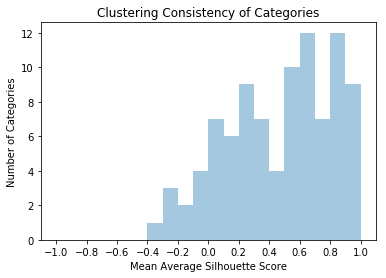

In [13]:
sns.distplot(sils_df.values, kde=False, bins=np.arange(-1, 1.1, 0.1))
plt.xticks(np.arange(-1, 1.2, 0.2))
plt.xlabel("Mean Average Silhouette Score")
plt.ylabel("Number of Categories")
plt.title("Clustering Consistency of Categories")
plt.show()

In [14]:
print("Most Consistent Clusters:")
sils_df.sort_values(ascending=False).head(10)

Most Consistent Clusters:


category
Sabrina The Teenage Witch             1.000000
Riverdale                             1.000000
The Chilling Adventures of Sabrina    1.000000
Twilight                              1.000000
Venture Capitalists                   1.000000
Teen Mom                              1.000000
Actors                                0.995315
Athletes                              0.963578
NFL Draft 2019                        0.954557
Rugby                                 0.949721
Name: mean_sil, dtype: float64

In [15]:
print("Most Inconsistent Clusters:")
sils_df.sort_values(ascending=True).head(10)

Most Inconsistent Clusters:


category
Hall of Famers     -0.324458
British Stars      -0.295055
Adult Film Stars   -0.271013
YouTubers          -0.246755
Entrepreneurs      -0.101013
Radio              -0.100580
Reality TV         -0.086035
Stylists           -0.059726
DJs                -0.050701
Fashion            -0.019295
Name: mean_sil, dtype: float64

In [16]:
print("Most Redundant Clusters:")
sils_df[abs(sils_df) <= 0.1].sort_values(ascending=False).head(10)

Most Redundant Clusters:


category
Chefs               0.077177
The Voice           0.067786
Bravo               0.064169
For Charity         0.050342
Playlist Live       0.049953
YouNow              0.048324
Spanish Language    0.004303
Fashion            -0.019295
DJs                -0.050701
Stylists           -0.059726
Name: mean_sil, dtype: float64

In [17]:
print("Second Peak:")
sils_df[sils_df <= 0.5].sort_values(ascending=False).head(10)

Second Peak:


category
13 Reasons Why       0.500000
Vlog Squad           0.469658
Food                 0.455730
MTV                  0.444238
UFC                  0.426398
Singer/Songwriter    0.393626
Extreme Sports       0.333017
Artists              0.327940
Olympics             0.326944
Podcast              0.322321
Name: mean_sil, dtype: float64

## Evaluate Simulated Data

In [18]:
mlb = MultiLabelBinarizer(classes=all_talent)
mlb.fit(trans_df["transactions"])
vecs = mlb.transform(trans_df["transactions"])
mat = pd.DataFrame(vecs)
trans_vecs_df = pd.DataFrame(vecs, columns=mlb.classes_)
min_likes = trans_vecs_df.sum(axis=1).min()
print("Each user has liked at least {} talent.".format(min_likes))
trans_vecs_df.head()

Each user has liked at least 22 talent.


,perezhilton,andydick,tjlavin,carsonkressley,riffraff,chumlee,gilbertgottfried,icet,benhiggy,laturtle,...,chrisjaialex,voman,el_peego,thisannaisbananas,zachharper,johnoberg,zacpullam,kansasbowling,mattcirulnick,itsscaleb__
0,1,0,0,0,1,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [19]:
from mlxtend.frequent_patterns import apriori

min_support = 0.05
freq_is = apriori(pd.DataFrame(trans_vecs_df), use_colnames=True, max_len=2, min_support=min_support)
freq_is["len"] = freq_is["itemsets"].apply(lambda s: len(s))
freq_is = freq_is.query("len == 2")
print("Found {} itemsets".format(len(freq_is)))
freq_is.sort_values(by="support", ascending=False).head()

Found 1287 itemsets


,support,itemsets,len
340,0.3444,"(laturtle, perezhilton)",2
431,0.3356,"(nickcolletti, laturtle)",2
462,0.2728,"(laturtle, codyko)",2
432,0.2590,"(laturtle, sonjatmorgan)",2
450,0.2538,"(todrick, laturtle)",2


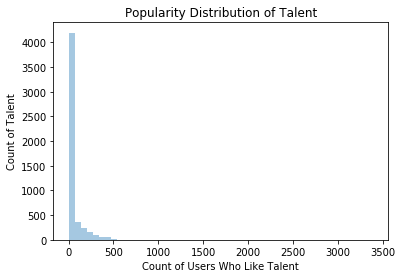

In [20]:
pop_dist = list(filter(lambda v: v > 0, mat.sum(axis=0).values))
sns.distplot(pop_dist, kde=False)
plt.xlabel("Count of Users Who Like Talent")
plt.ylabel("Count of Talent")
plt.title("Popularity Distribution of Talent")
plt.show()

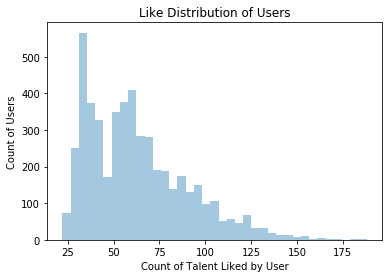

In [21]:
sns.distplot(mat.sum(axis=1).values, kde=False)
plt.xlabel("Count of Talent Liked by User")
plt.ylabel("Count of Users")
plt.title("Like Distribution of Users")
plt.show()

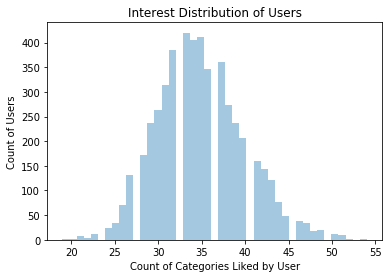

In [22]:
cat_lens = trans_df["categories"].apply(lambda s: len(s)).values
sns.distplot(cat_lens, kde=False)
plt.xlabel("Count of Categories Liked by User")
plt.ylabel("Count of Users")
plt.title("Interest Distribution of Users")
plt.show()

## Save Transaction Matrix

In [23]:
mat.head()

,0,1,2,3,4,5,6,7,8,9,...,5382,5383,5384,5385,5386,5387,5388,5389,5390,5391
0,1,0,0,0,1,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [24]:
ITEM_NAMES = mlb.classes_
ITEM_NAMES

array(['perezhilton', 'andydick', 'tjlavin', ..., 'kansasbowling',
       'mattcirulnick', 'itsscaleb__'], dtype=object)

In [25]:
from scipy.sparse import csr_matrix
import pickle

like_mat = csr_matrix(mat.values)
like_file = "../input/likes.pkl"
pickle.dump(like_mat, open(like_file, "wb"))
print("Wrote {} records to {}.".format(len(mat), like_file))

Wrote 5000 records to ../input/likes.pkl.
